# DryWetLab
This notebook contains some explanations of plus a variety of experiments using the simulated organoids and test equipment from the library `braingeneers.drylab`.

In [1]:
%matplotlib nbagg
import numpy as np
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation

from tqdm import tqdm_notebook as tqdm
from colorednoise import powerlaw_psd_gaussian as gen_noise

from braingeneers import drylab

In [2]:
# This is specific to my MPL configuration...
plt.style.use('arxiv')

140.0

# BRAAAAAAINS
Create an Organoid object representing 1000 cortical neurons at uniformly random locations in the region of interest. The scale of the physical position for organoids is unknown. In chimpanzee neocortex, Collins (2016) gives about 20 million cells per square centimeter of cortical surface. That means 1000 cells exist in an area 70$\mu m$ on a side. We used this value previously, but have increased the size arbitrarily on the assumption that functioning cells in organoids are less dense than in real cortex. 

The neuron parameters are of course adapted from Izhikevich's work, a combination of the approach from the 2003 paper (whose demonstration is reproduced here) with the data from _Dynamical Systems in Neuroscience_. Two different versions of the model are used in these two sources, and although they are obviously topologically conjugate, they are not algebraically equivalent for any set of parameter values. Since the network dynamics are very sensitive to parameters (although not very sensitive to initial conditions), this has meant that I have not been able to reproduce the clear $\alpha$ and $\gamma$ rhythms of the original demonstration.

In [30]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))
# mV : peak cutoff of action potentials
Vp = 30

# tau : ms time constant of synaptic current
tau = np.hstack((5*l[:Ne], 20*l[Ne:]))


Here, we generate synaptic weights $S_{ij}$ distributed according to Song (2005), who described measurements of EPSPs in layer-V pyramidal cells in rat V1. The result was that EPSP strength is lognormally distributed (they gave parameters, which are reproduced below) and does not depend substantially on distance within the range of about 50um that they tested. Values sampled from their distribution are converted from mV EPSPs to pA EPSCs by multiplying by a typical value of $C\over\tau$ (the membrane capacitance divided by the EPSC decay time constant); this can be derived by integrating the effect of the EPSC on the membrane voltage in the absence of leakage and setting it equal to the desired EPSP value.

Song measured only *E*PSPs, but I need to consider inhibitory cells as well in order to have any hope of reproducing the dynamics of real neurons. Here, I make the certainly-false assumption that inhibitory cells have a similar distribution, but are stronger than excitatory cells to make up for their lesser numbers and greater locality.

Both types of synaptic strengths are made distance-dependent based on defensible but handwavey morphological arguments. Excitatory cells are assumed to be pyramidal, with a long axon which can project far from the body, but tends to synapse on cells which are fairly nearby. This is represented with an alpha function so that there is an optimal distance $d_{\text{exc}}$ for excitatory strength. Inhibitory cells, on the other hand, are assumed to be basket cells, with a dense tree of neurites but a small radius $d_{\text{inh}}$ over which inhibitory strength is constant and outside of which the cell has no direct influence.

In [31]:
# Sij : fC total postsynaptic charge injected into
#       neuron i when neuron j fires. Song (2005)
#       provide an empirical distribution for EPSPs.
mu, sigma = -0.702, 0.9355  
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
# Then convert the EPSPs to injected synaptic charge.
S *= np.median(C / tau) * 10

# XY : um planar positions of the cells,
# dij : um distances between cells
XY = np.random.rand(2,N) * 75
dij = np.sqrt(np.sum((XY[:,:,None] - XY[:,None,:])**2, 
                     axis=0))

# d_exc : um characteristic distance of excitatory connections
d_exc = 20

# Make excitatory synapse strength follow an alpha
# function shape with parameter d_exc. 
def dist_func(theta):
    return theta * np.exp(-theta)
S[:,:Ne] *= dist_func(dij[:,:Ne] / d_exc)


# d_inh : um distance over which inhibitory connections act
d_inh = 20

# Make inhibitory synapse strength unaffected by 
# distance within a radius d_inh, but 0 outside.
S[:,Ne:][dij[:,Ne:] > d_inh] = 0
S[:,Ne:] *= -5

<IPython.core.display.Javascript object>


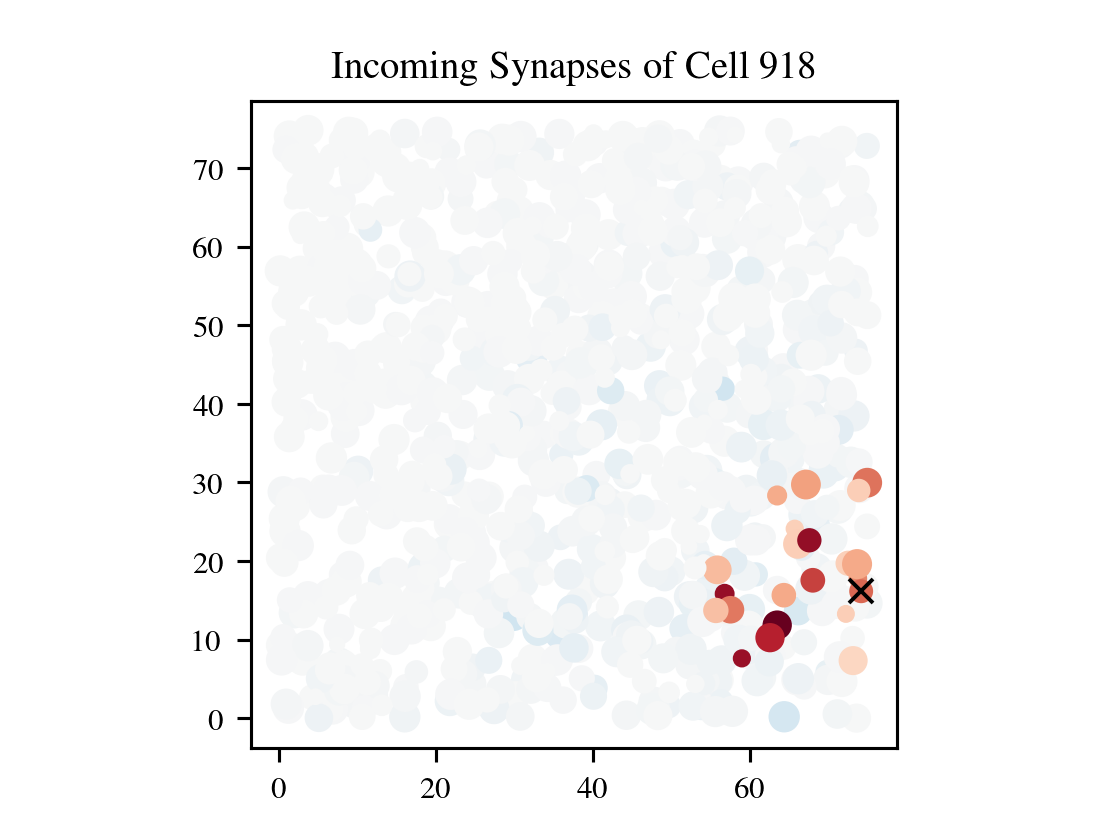

Text(0.5, 1.0, 'Incoming Synapses of Cell 918')

In [32]:
plt.figure()
plt.gca(aspect='equal')
cell = np.random.randint(N)
strongest = np.abs(S[cell,:]).max()
plt.scatter(XY[0,:], XY[1,:], s=C/2, cmap='RdBu', c=S[cell,:], 
            norm=mpl.colors.Normalize(vmin=-strongest,
                                      vmax=strongest))
plt.plot(XY[0,cell], XY[1,cell], 'kx')
plt.title('Incoming Synapses of Cell ' + str(cell))

<IPython.core.display.Javascript object>


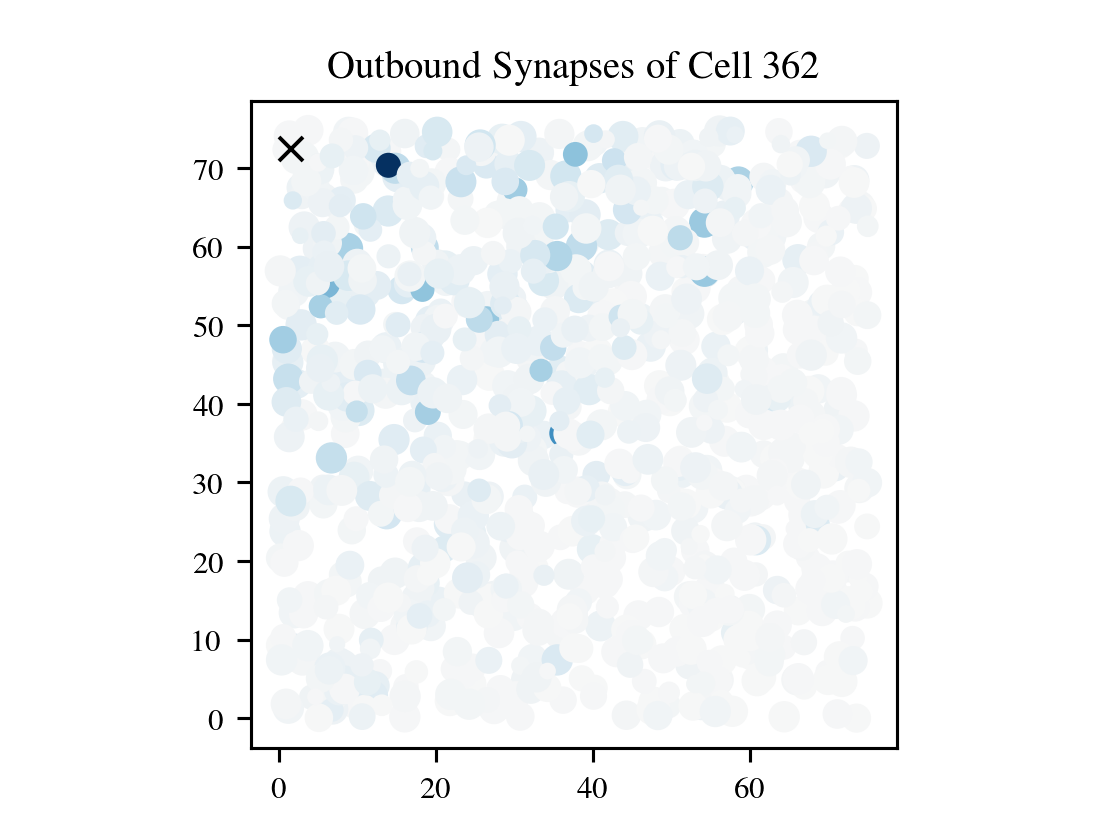

Text(0.5, 1.0, 'Outbound Synapses of Cell 362')

In [33]:
plt.figure()
plt.gca(aspect='equal')
cell = np.random.randint(N)
strongest = np.abs(S[:,cell]).max()
plt.scatter(XY[0,:], XY[1,:], s=C/2, cmap='RdBu', c=S[:,cell], 
            norm=mpl.colors.Normalize(vmin=-strongest,
                                      vmax=strongest))
plt.plot(XY[0,cell], XY[1,cell], 'kx')
plt.title('Outbound Synapses of Cell ' + str(cell))

### Plot firings over time.

In [34]:
from functools import wraps

def apply_to_args(fun):
    """
    Returns a decorator which applies fun to 
    all arguments of the wrapped function.
    """
    def decorator(f):
        @wraps(f)
        def wrapped(*args, **kw):
            return f(*(fun(arg) 
                       for arg in args),
                     **kw)
        return wrapped
    return decorator

@apply_to_args(np.atleast_1d)
def quantize(space, data):
    """
    Replace points in DATA with the closest 
    point in SPACE. For quantizing to grids!
    """
    return space[np.argmin(abs(space[None,...] - data[...,None]), 
                           axis=1)]

In [36]:
# Sample rate (kHz) and timestep (ms)
fs = 1
dt = 1/fs
tmax = 1000

time = np.linspace(0, tmax, tmax*fs, endpoint=False)
pinks = 50*gen_noise(size=(N,tmax), exponent=1)
pinks = signal.resample(pinks, len(time), axis=1)

# Quantize org.XY to the grid.
X = Y = np.linspace(-30,100, 101)
XY_quantized = np.array([quantize(X, XY[0]), 
                         quantize(Y, XY[1])])

# Create the actual Organoid.
org = drylab.Organoid(XY=XY_quantized, S=permuted_S, tau=tau, Vp=Vp,
                      a=a, b=b, c=c, d=d, k=k, C=C, Vr=Vr, Vt=Vt)


# Put 8 probes in a circle in a charged medium.
n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
points = np.array([quantize(X, points[0]), 
                   quantize(Y, points[1])])

well = drylab.ChargedMedium(X, Y, D=2, eps_rel=80)
well.immerse(org)
well.probe_at(points)
well._r = np.maximum(well._r, 1)
well._d = np.maximum(well._d, 1)

In [38]:
# Initialize and run the loop.

spike_times, spike_idces = [], []
Vprobe = np.zeros((n_probes, len(time)))
for ti,t in tqdm(enumerate(time), total=len(time)):

    Iin = pinks[:,ti%1000]
    org.step(dt, Iin)

    well.step(dt)
    Vprobe[:,ti] = well.probe()

    for i in np.arange(N)[org.fired]:
        spike_times.append(ti)
        spike_idces.append(i)

spike_times = np.array(spike_times)
spike_idces = np.array(spike_idces, dtype=np.int32)

<IPython.core.display.Javascript object>


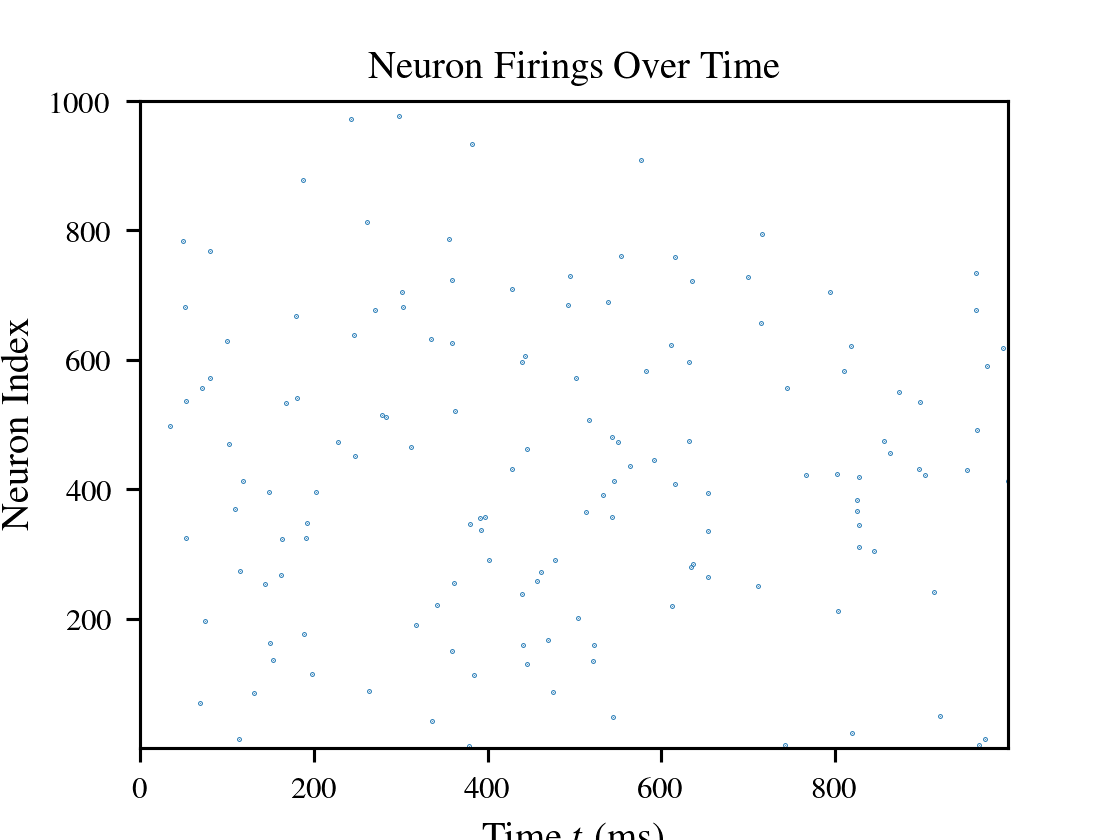

(1, 1000)

In [39]:
plt.figure()
plt.plot(spike_times, spike_idces + 1, '.', markersize=0.5)
plt.title('Neuron Firings Over Time')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0,tmax-1])
plt.ylim([1,N])

## Extracellular Probes
Demonstrates the output of the above extracellular probe before and after the classic bandpass filter. Results are strange. This is probably a recently introduced bug... 

In [55]:
def butter_bandpass(x, locut, hicut, fs, order=5):
    "Apply a Butterworth bandpass filter."
    if hicut < fs/2:
        sos = signal.butter(order, [locut, hicut], fs=fs,
                            btype='bandpass', output='sos')
    else:
        sos = signal.butter(order, locut, fs=fs, 
                          btype='highpass', output='sos')
    return signal.sosfilt(sos, x)

Vfilt = butter_bandpass(Vprobe, 0.3, 10, fs=fs, order=5)

<IPython.core.display.Javascript object>


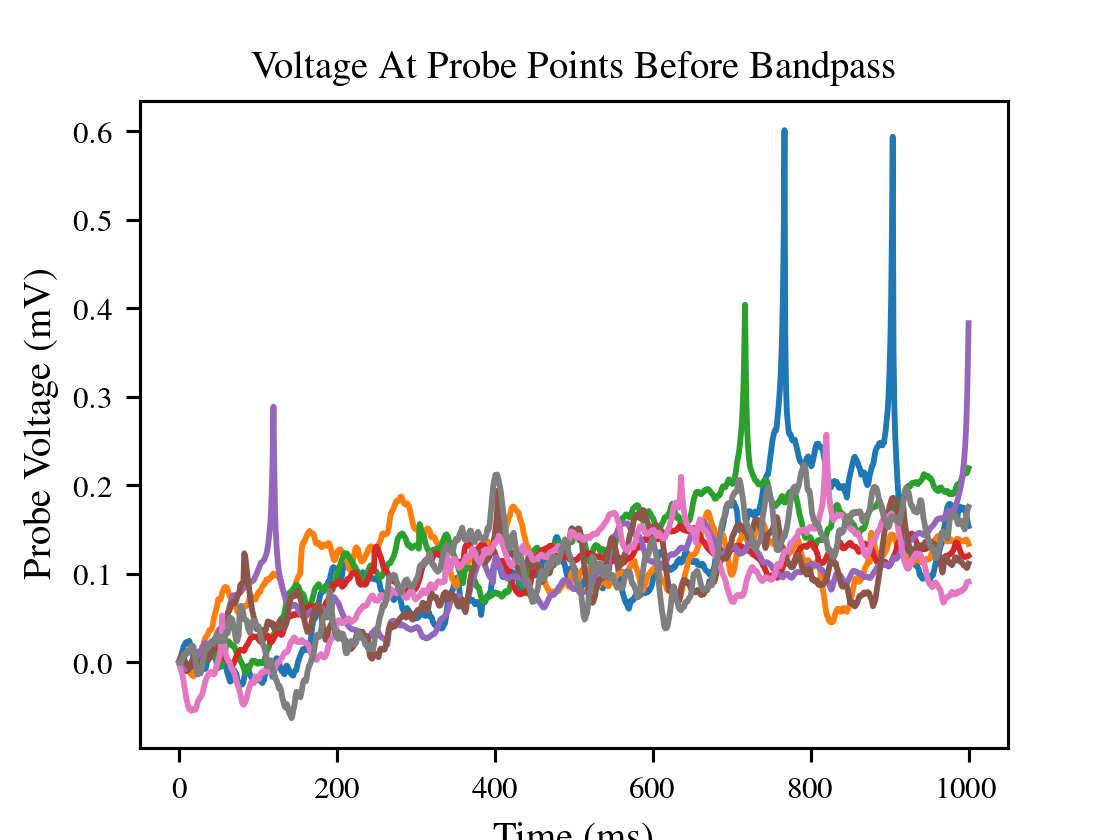

In [56]:
plt.figure()
plt.plot(time, Vprobe.T)
plt.title('Voltage At Probe Points Before Bandpass')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

<IPython.core.display.Javascript object>


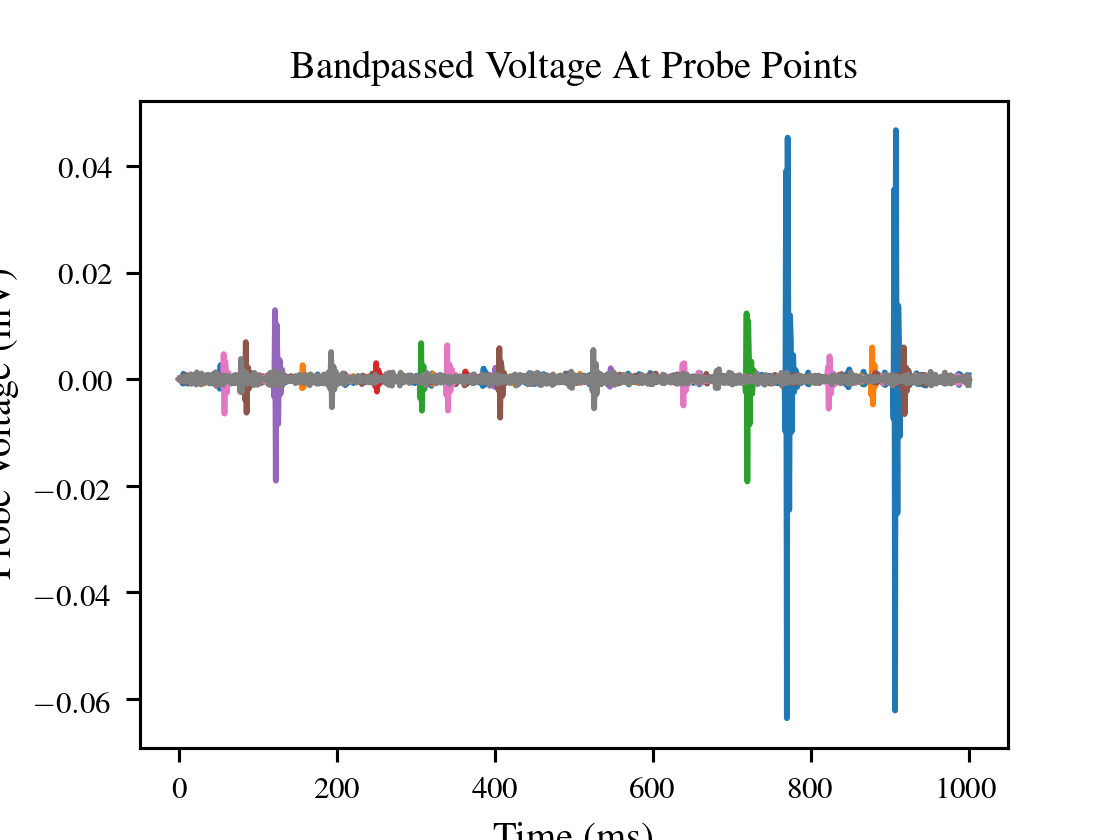

In [58]:
plt.figure()
plt.plot(time, Vfilt.T)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

## Ca2+ Video
Use the recorded spike times to generate a video of activity.

<IPython.core.display.Javascript object>


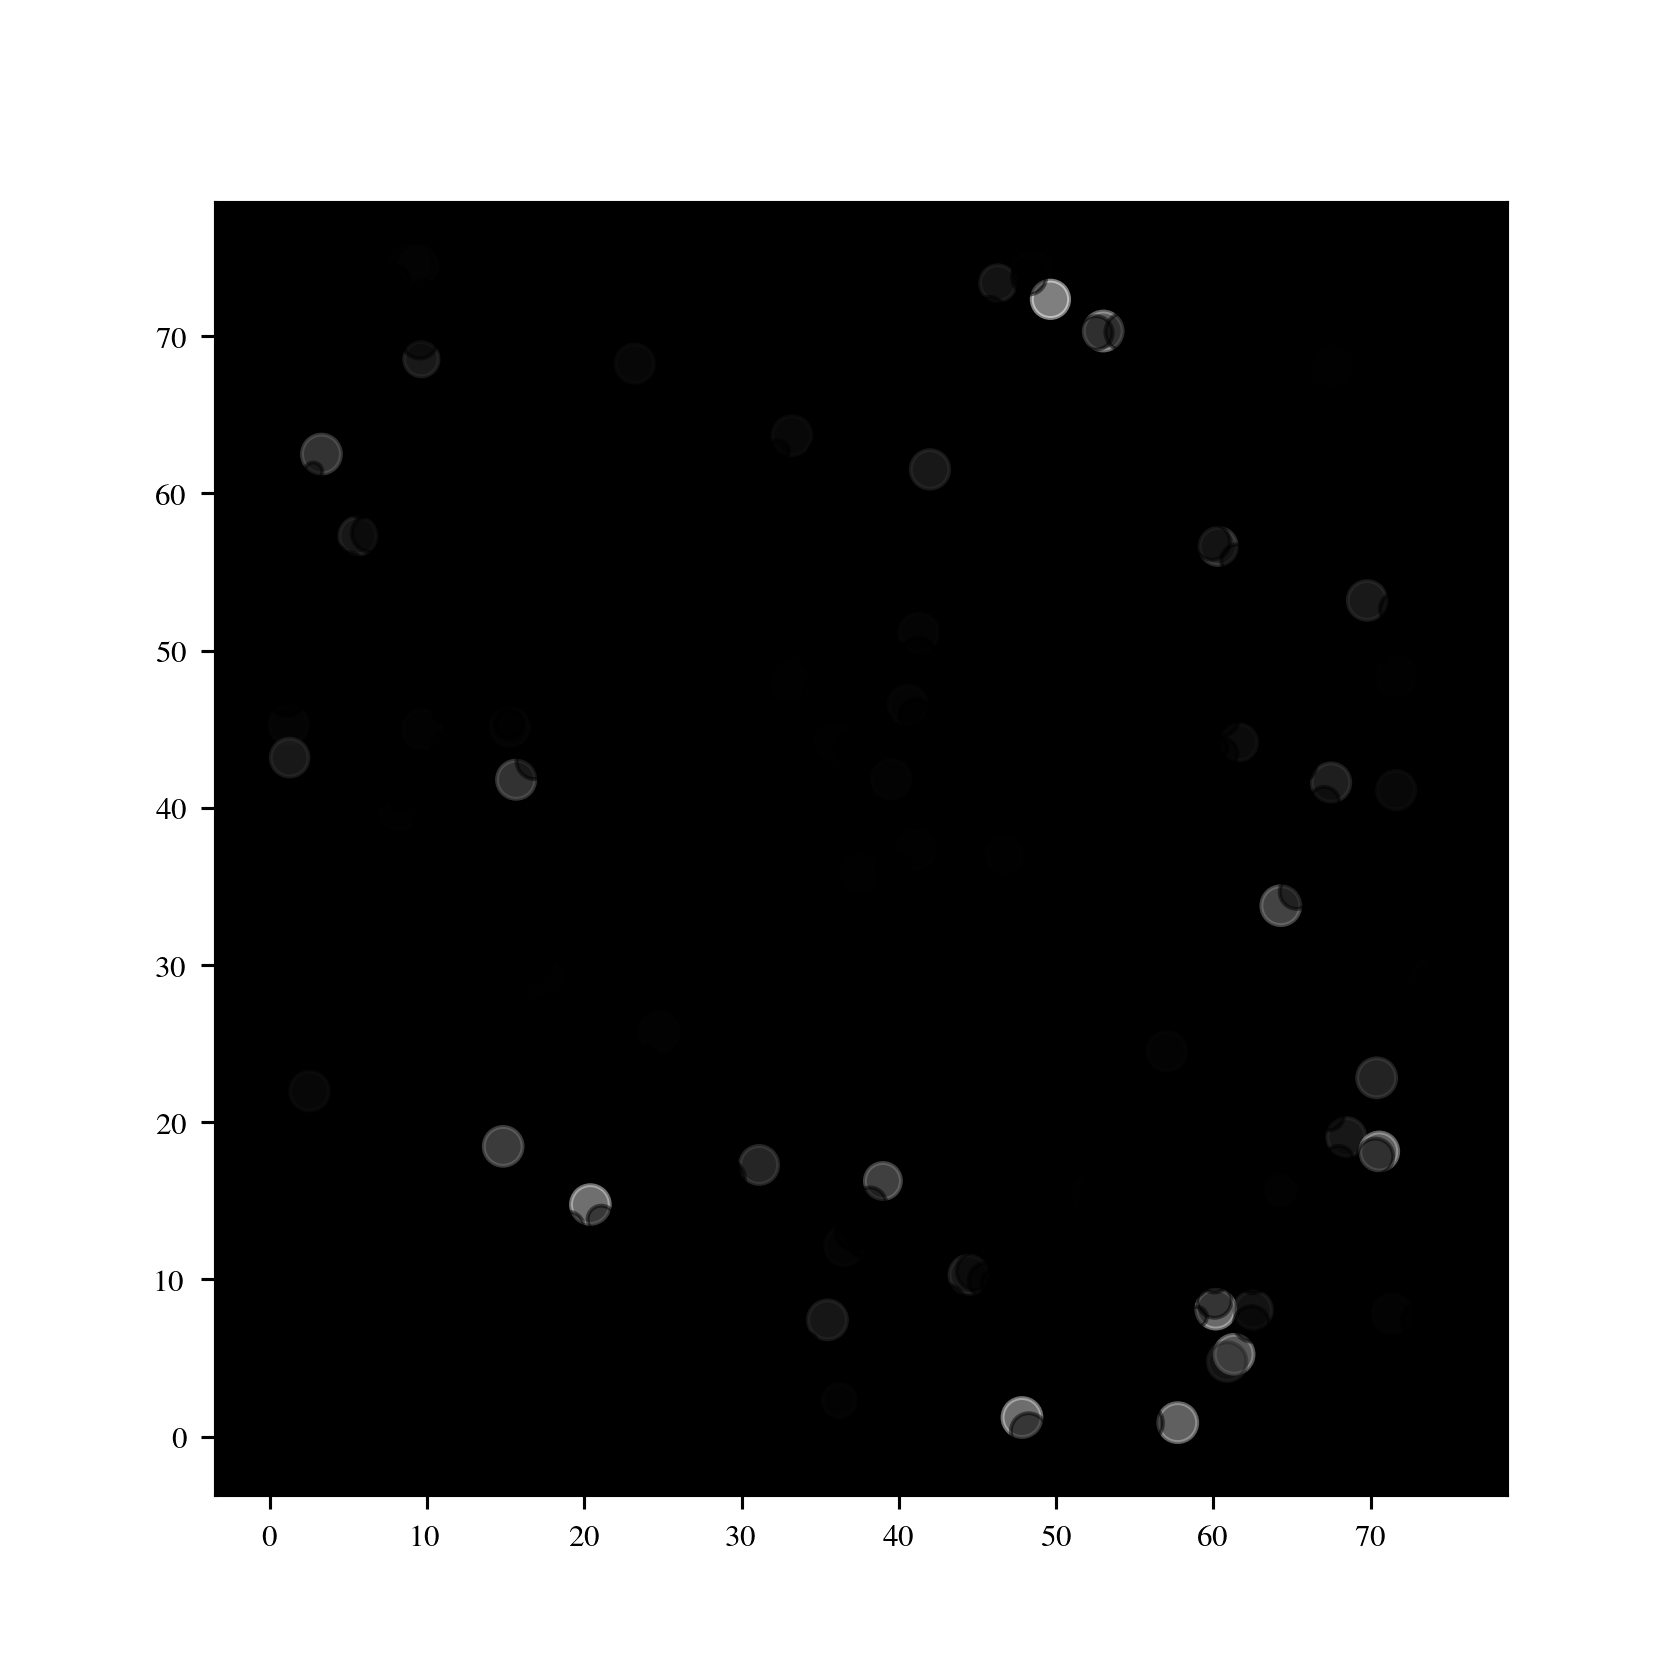

In [51]:
fig = plt.figure(figsize=(6,6))
img = drylab.Ca2tImage(XY, C, tau=100, fig=fig, reactivity=5)
img.animate(10, zip(spike_times, spike_idces), 
            save_count=len(spike_times), repeat=True)

# Bibliography

Izhikevich, E. M. (2007). Dynamical systems in neuroscience. MIT press.
> This book is the best source of the computationally
> efficient neuron model I used (albeit not with as much
> physical explanation as I attempted to provide, but at
> least the units check out now), with demonstrations
> of how to tune the parameters to reproduce the behavior
> of actual cell types measured in vivo, as well as
> dynamical systems analyses of the resulting models.
> It's also a pretty good introduction to bifurcation theory!

Song, S., Sjöström, P. J., Reigl, M., Nelson, S., & Chklovskii, D. B. (2005). Highly nonrandom features of synaptic connectivity in local cortical circuits. _PLoS biology_, 3(3), e68.
> This paper describes the measured distribution of EPSPs
> generated by layer-V pyramidal cells in rat V1. I used
> its results as a guess as to the synaptic distribution
> in our organoids, under the assumption that "cortex is
> cortex", which is patently ridiculous. :) Eventually,
> The distribution will be modified by STDP and other
> forms of plasticity, making the prior less important.